# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [5]:
data.shape
sum(data.call)

392.0

In [6]:
# Set up the appearance of the plots
sns.set()

# Seed np.random
np.random.seed(42)

# Set up a cdf function to quickly see distributions.
def ecdf(data):
    '''Compute continuous distribution function for one column'''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

# Set up a function to generate bootstrap replicates
def bs_reps(data, func, size=1):
    '''Draw boostrap replicates'''
    # Initialize empty array
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))
    return bs_replicates

# Set up a function to permute data sets
def permutation_sample(data1, data2):
    '''Generate a permuted sample from two data sets'''
    # Concatenate the data sets
    data = np.concatenate((data1, data2))
    # Permute the concatenated array
    permuted_data = np.random.permutation(data)
    # Split the permuted data back into two data sets
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

# Set up a function to generate permutation replicates
def draw_perm_reps(data1, data2, func, size=1):
    '''Draw permutation replicates'''
    # Initialize empty array of proper size
    perm_replicates = np.empty(size)
    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data1, data2)
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

# Set up a function to calculate differences of means
def diff_of_means(data1, data2):
    '''Calculate difference of means of two arrays'''
    diff = np.mean(data1) - np.mean(data2)
    return diff

<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

### 1.  What test is appropriate for this problem? Does CLT apply?

This is a difference of proportions.  A two-tailed z-test will be used.

CLT applies to this dataset:
* Random:  We will trust the question, as it states that the assignments to the sample are random.
* Independent:  The occurrence of one row entry has no influence on the next row, and the sample can be assumed to be less than 10% of any of the US adult population BLS statistics.  (Approx. 330m US adults, approx. 129m full-time adult workers, approx. 5m unemployed US adults actively seeking work, etc.)
* Size:  The sample is sufficiently large at 4870 rows.

### 2.  What are the null and alternate hypotheses?

* H0: proportion of black-sounding callbacks equals proportion of white-sounding callbacks  (w.call == b.call, or racial bias doesn't exist)
* Ha: proportions are not equal  (w.call != b.call, or racial bias exists)
* alpha = .05

In [7]:
w = data.loc[data.race=='w']
b = data.loc[data.race=='b']

# Get some basic info on the sample data
callbacks = np.mean(data.call)
callbacks_w = np.mean(w.call)
callbacks_b = np.mean(b.call)
observed_diff = diff_of_means(callbacks_w, callbacks_b)
print('{:.4f}'.format(callbacks*100), '- percent of sample receives a call')
print('{:.4f}'.format(callbacks_w*100), '- percent of white-sounding sample receives a call (', np.sum(w.call), ')')
print('{:.4f}'.format(callbacks_b*100), '- percent of black-sounding sample receives a call (', np.sum(b.call), ')')
print('{:.4f}'.format(observed_diff*100), '- percent difference of means of callbacks in the sample')

8.0493 - percent of sample receives a call
9.6509 - percent of white-sounding sample receives a call ( 235.0 )
6.4476 - percent of black-sounding sample receives a call ( 157.0 )
3.2033 - percent difference of means of callbacks in the sample


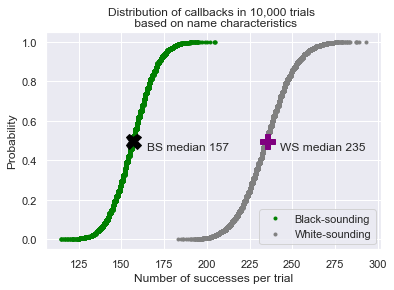

In [8]:
# Check the separate cdfs of the expected successes, binomial distribution only used to generate a curve
samples_w = np.random.binomial(len(w), callbacks_w, 10000)
xw, yw = ecdf(samples_w)
samples_b = np.random.binomial(len(b), callbacks_b, 10000)
xb, yb = ecdf(samples_b)
mid50_w = np.percentile(samples_w, 50)
mid50_b = np.percentile(samples_b, 50)

# Make pretty plots
_ = plt.plot(xb, yb, marker='.', linestyle='none', color='green')
_ = plt.plot(xw, yw, marker='.', linestyle='none', color='gray')
_ = plt.xlabel('Number of successes per trial')
_ = plt.ylabel('Probability')
_ = plt.legend(('Black-sounding', 'White-sounding'))
_ = plt.title('Distribution of callbacks in 10,000 trials \n based on name characteristics')
_ = plt.plot(mid50_w, .5, marker='P', color='purple', markersize=15)
_ = plt.plot(mid50_b, .5, marker='X', color='black', markersize=15)
_ = plt.text(x=mid50_w+8, y=.45, s='WS median 235')
_ = plt.text(x=mid50_b+8, y=.45, s='BS median 157')

<div class="span5 alert alert-success">
<p>Your answer to Q3 here</p>
</div>

### 3.  Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

* The margin of error is 0.0152551 (1.53%)
* The expected difference in callbacks between black-sounding and white-sounding names is 1.68% to 4.73%, much higher than the H0 of 0%.  (95% confidence interval is 0.01678 to 0.04729.)
* The p-value is 3.983886904990186e-05 (0.0000398, very low, reject H0)
* The bootstrap replicates produced zero instances of a difference of means equal to or larger than the observed difference of 3.20%.

In [9]:
# Difference of proportion z-test, 2-tailed test

#callbacks, callbacks_w, callbacks_b = proportions
#observed_diff = difference between callbacks_w, callbacks_b

n_b = len(b.call)
n_w = len(w.call)
cb = callbacks

cb_p = cb*(1-cb)
cb_pb = callbacks_b*(1-callbacks_b)
cb_pw = callbacks_w*(1-callbacks_w)

tail = 2

z = observed_diff / np.sqrt(cb_p*((1/n_b)+(1/n_w)))
z_crit = stats.norm.ppf(.975)
moe = z_crit*np.sqrt((cb_pb/n_b)+(cb_pw/n_w))
ci_high = observed_diff + moe
ci_low = observed_diff - moe
z_pval = (1-stats.norm.cdf(z))*tail

print('The margin of error is', '{:.7f}'.format(moe), '(', '{:.2f}'.format(moe*100), 'percent )')
print('The 95% confidence interval is', '{:.7f}'.format(ci_low), 'to', '{:.7f}'.format(ci_high), '(','{:.2f}'.format(ci_low*100), 'to', '{:.2f}'.format(ci_high*100), 'percent difference )')
print('The p-value is', z_pval, '(', '{:.7f}'.format(z_pval), ')')

The margin of error is 0.0152551 ( 1.53 percent )
The 95% confidence interval is 0.0167777 to 0.0472880 ( 1.68 to 4.73 percent difference )
The p-value is 3.983886904990186e-05 ( 0.0000398 )


In [10]:
# Bootstrap calculations (individual populations and permutations)

# Get several bootstrap replicates of proportion to receive calls
bs_replicates_w = bs_reps(w.call, np.mean, 10000)
bs_replicates_b = bs_reps(b.call, np.mean, 10000)

# Get the confidence intervals
ci = stats.norm.interval(0.95, loc=np.mean(data.call), scale=stats.sem(data.call))
ci_w = stats.norm.interval(0.95, loc=np.mean(w.call), scale=stats.sem(w.call))
ci_b = stats.norm.interval(0.95, loc=np.mean(b.call), scale=stats.sem(b.call))

# Use the call info to create permutation replicates of the difference of means
perm_replicates = draw_perm_reps(w.call, b.call, diff_of_means, 10000)

# Calculate p-value and confidence interval 
p = np.sum(perm_replicates >= observed_diff) / len(perm_replicates)

# Print the results
print('p-value of bootstraped replicates:', p, '(below .05, reject H0, proportions of callbacks are NOT equal)')
print('95% confidence interval for percent of population to receive calls:    ','{:.4f}'.format(ci[0]*100),'to','{:.4f}'.format(ci[1]*100))
print('95% confidence interval for percent of white-sounding to receive calls:','{:.4f}'.format(ci_w[0]*100),'to','{:.4f}'.format(ci_w[1]*100))
print('95% confidence interval for percent of black-sounding to receive calls:','{:.4f}'.format(ci_b[0]*100),'to','{:.4f}'.format(ci_b[1]*100))

p-value of bootstraped replicates: 0.0 (below .05, reject H0, proportions of callbacks are NOT equal)
95% confidence interval for percent of population to receive calls:     7.2851 to 8.8134
95% confidence interval for percent of white-sounding to receive calls: 8.4778 to 10.8240
95% confidence interval for percent of black-sounding to receive calls: 5.4719 to 7.4233


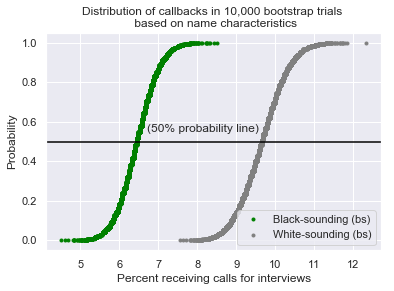

In [11]:
bs_replicates_b_ = bs_replicates_b*100
bs_replicates_w_ = bs_replicates_w*100
xb, yb = ecdf(bs_replicates_b_)
xw, yw = ecdf(bs_replicates_w_)

# Make pretty plots
_ = plt.plot(xb, yb, marker='.', linestyle='none', color='green')
_ = plt.plot(xw, yw, marker='.', linestyle='none', color='gray')
_ = plt.xlabel('Percent receiving calls for interviews')
_ = plt.ylabel('Probability')
_ = plt.legend(('Black-sounding (bs)', 'White-sounding (bs)'))
_ = plt.title('Distribution of callbacks in 10,000 bootstrap trials \n based on name characteristics')
_ = plt.axhline(.5, color='black')
_ = plt.text(x=6.7, y=.55, s='(50% probability line)')

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

### 4.  Write a story describing the statistical significance in the context or the original problem.

When researchers sent identical resumes out, they received a higher number of callbacks for interviews for those sent out under white-sounding names.  After graphical and numerical analysis, we have discovered that this higher number is statistically significant in both frequentist and bootstrap testing.  We reject the null hypothesis that there is no racial bias in favor of the alternate hypothesis, that racial bias exists.

### 5.  Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

The race assumed from the name certainly appears to have an effect on the rate of callbacks -- we rejected H0, the hypothesis that there is no difference in the rates -- but didn't test for any other factor.  The dataset authors claim to have eliminated bias, and we have no other data from which to work.

Other factors that could exist in a similar real-world dataset include years of experience, level of education (and tier of school), additional certifications or honors, the number and length of previous positions (including volunteer and military), gaps in work history, previous titles, and employment in related industries, just to start.